# SCAnalysis for single cell RNA-seq

This notebook details the usage of SCAnalysis for single cell RNA-seq data.

To view directly: https://nbviewer.jupyter.org/github/helenjin/scanalysis/blob/master/notebooks/SCAnalysis.ipynb
*(ignore if already here)*

## Table of Contents

1. [Introduction](#intro)
2. [Loading Data](#loading)
3. [Data Preprocessing](#preprocessing):
    *a. [Data Filtering](#filter)
    b. [Data Normalization](#norm)
    c. [PCA](#pca)
    d. [Diffusion maps](#dmap)
    e. [tSNE](#tsne)*
4. [Saving data](#savedata)
5. [General Plots](#genplot):
    *a. [PCA visualization](#pcavisual)
    b. [tSNE visualization](#tsnevisual)
    c. [Diffusion maps visualization](#dmvisual)*   
6. [Gene Set Enrichment Analysis (GSEA)](#gsea)
7. [Running Wishbone](#wishbone)
8. [Plotting Wishbone Results](#wbplot)
9. [Running MAGIC](#magic)
10. [Plotting MAGIC Results](#mgplot):
    *a. [PCA scatter plots](#magicpcaplots)
    b. [tSNE scatter plots](#magictsneplots)*
11. [Saving figures](#savefig)
12. [Running Palantir](#palantir)
13. [Plotting Palantir Results](#prplot)
14. [References](#ref)

<a id="intro"></a>
## Introduction

SCAnalysis is a package for analyzing single cell data. It includes the Wishbone, MAGIC, and Palantir packages:

* Wishbone is an algorithm to identify bifurcating developmental trajectories from single cell data. Wishbone can applied to single cell RNA-seq (as for mass cytometry datasets--> not currently)

* MAGIC (Markov-Affinity Based Graph Imputation of Cells) is an interactive tool to impute missing values in single-cell data and restore the structure of the data. It also provides data preprocessing functionality such as dimensionality reduction and gene expression visualization.

* Palantir -tbd

<a id="loading"></a>
## Loading Data

First, import the package.

In [1]:
import scanalysis

Then, you can load the data using the load function in the loadsave file of the io folder. Here, we will be using the sample_scseq_data.csv data provided in the data folder as an example.

In [21]:
df = scanalysis.io.loadsave.load("~/scanalysis/data/sample_scseq_data.csv")

Successfully loaded /Users/hjin/scanalysis/data/sample_scseq_data.csv as a pd.DataFrame object


Also, import plotting and miscellaneous.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

<a id="preprocessing"></a>
## Data preprocessing 

<a id="filter"></a>
### Data filtering

In [ ]:
fig, ax = scanalysis.plots.plot.plot_molecules_per_cell_and_gene(df)

From these histograms, choose the appropriate cutoffs to filter the data. In this case, the data has already been filtered.

In [5]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

In [4]:
df = scanalysis.io.preprocess.filter_scseq_data(df, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)

NameError: name 'CELL_MIN' is not defined

<a id="norm"></a>
### Data normalization

In [22]:
data = scanalysis.io.preprocess.normalize_scseq_data(df)

Successfully normalized data


<a id="pca"></a>
### Principal Component Analysis (PCA)

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

For a visual representation of PCA results, see [PCA visualization](#pcavisual). *However, note that the PCA visualization functions already run PCA within themselves, so there is no need to run PCA separately beforehand.*

In [14]:
r1, r2 = scanalysis.utils.pca.run_pca(data)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


##### *Note: This sample dataset is especially sensitive, so we will be using the PCA of the original Wishbone package. (as shown below)

temp is the data after PCA is run on it.

In [23]:
import wishbone
import os

scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), data_type='sc-seq', normalize=True)
scdata.run_pca()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
from copy import deepcopy
import numpy as np
import pandas as pd

n_pca_components = 5
temp = deepcopy(scdata.data)
temp -= np.min(np.ravel(temp))
temp /= np.max(np.ravel(temp))
temp = pd.DataFrame(np.dot(temp, scdata.pca['loadings'].iloc[:, 0:n_pca_components]),
                    index=scdata.data.index)

<a id="dmap"></a>
### Diffusion Maps

Diffusion maps is a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the run_diffusion_map function and the diffusion components visualized on tSNE maps using plot_diffusion_components. See [Diffusion map visualization](#dmvisual)

Note: PCA must be run separately on data before diffusion maps (i.e. PCA is not included in diffusion maps function)

In [25]:
tempEigvec, tempEigval = scanalysis.utils.diffusionmap.run_diffusion_map(temp)

Running Diffusion maps with the following parameters:
Normalization: smarkov
Number of nearest neighbors k: 10
Epsilon: 1.0000
(symmetric markov) ... 
0.25 seconds
Successfully ran diffusion map, and returning EigenVectors and EigenValues


<a id="tsne"></a>
### tSNE

Note: [PCA](#pca) must be run separately on data before tSNE (i.e. PCA is not included in tSNE function)

For a visual representation of tSNE results, see [tSNE visualization](#tsnevisual)

Here, temp data has already been run through PCA, so we can simply apply tSNE:

In [20]:
t = scanalysis.utils.tsne.TSNE()
d = t.fit_transform(temp)

In [15]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

<a id="savedata"></a>
## Saving Data **might need to revise

Data can be saved to a pickle file and loaded using the save and load functions. 

In [ ]:
scanalysis.io.loadsave.save(data, 'mouse_marrow_scdata.p')
p = scanalysis.io.loadsave.load('mouse_marrow_scdata.p')

<a id="genplot"></a>
## General Plots

<a id="pcavisual"></a>
### PCA visualization

*Note: Run the plot_pca_variance_explained function WITHOUT running PCA on the data beforehand, since PCA will be run automatically.*

Results shown below for plot_pca_variance_explained_v1, which is Wishbone's version of the function.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v1(data, n_components=40, random=True)

Results shown below for plot_pca_variance_explained_v2, which is MAGIC's version of the function.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v2(data, n_components=40, random=True)

<a id="tsnevisual"></a>
### tSNE visualization

Wishbone uses [tSNE](#tsne) for visualization and tSNE can be run using the run_tsne function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

tSNE results can be visualized by the plot_tsne and plot_tsne_by_cell_sizes functions. The plot_tsne_by_cell_sizes function colors the cells by their molecule counts before normalization.

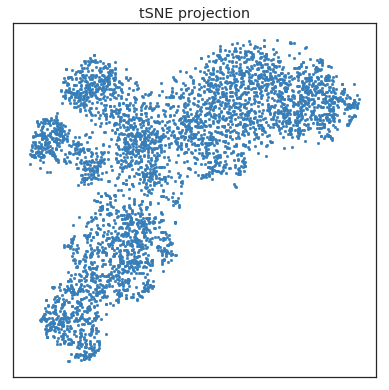

In [16]:
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

(<matplotlib.figure.Figure at 0x11aab6860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11aab6198>)

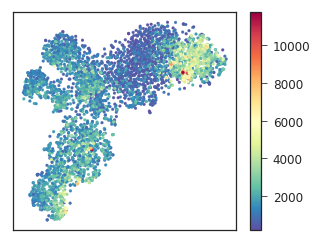

In [17]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(df, d1, fig = fig)

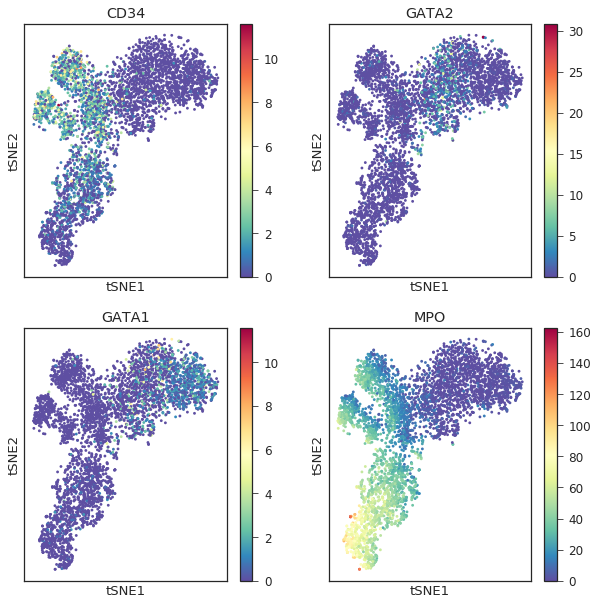

In [19]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data, d1, genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

<a id="dmvisual"></a>
### Diffusion map visualization

*Note: Please run [diffusion maps](#dmap) and [tSNE](#tsne) before plotting diffusion components (via plot_diffusion_components function).*

In [ ]:
fig, ax = scanalysis.plots.plot.plot_diffusion_components(d, tempEigvec, tempEigval)

The run_diffusion_map_correlations function is designed to work for single cell RNA-seq (not mass-cyt).
Please run diffusion maps using run_diffusion_map before determining correlations.

Note: the component 0 is the trivial component and does not encode any information of the data.

In [ ]:
dmap_corr = scanalysis.plots.plot.run_diffusion_map_correlations(data, tempEigvec)

After determining the diffusion map correlations, we can plot the gene component correlations (via plot_gene_component_correlations function).

In [ ]:
scanalysis.plots.plot.plot_gene_component_correlations(dmap_corr)

<a id="gsea"></a>
## Gene Set Enrichment Analysis (GSEA)
For more info on the original software, see [GSEA](http://software.broadinstitute.org/gsea/index.jsp)

The enrichments can be determined using the run_gsea function. This function needs the prefix for generating GSEA reports and a gmt file representing the different gene sets. The following invocation of the function shows the supported set of gmt files.

*Note: Please make sure to run run_diffusion_map_correlations() before running GSEA to annotate those components.*

Note: The gmt files package with Wishbone/SCAnalysis assume all the gene names to be upper case. This can be ensured using the following code to convert them to upper case.

In [ ]:
data.columns = data.columns.str.upper()

In [ ]:
scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/tools/gsea/mouse_marrow'))

Since this is data from mouse, gmt_file parameter can be set to (mouse, gofat.bp.v1.0.gmt.txt)

In [ ]:
reports = scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/gsea/mouse_marrow'), 
                          gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

The detailed reports can be found at ~/.wishbone/gsea/

In [ ]:
!open ~/.scanalysis/gsea/

run_gsea function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this dataset, components 1 and 2 show relevant enrichments and are used for running Wishbone/SCAnalysis. Please see Selection of diffusion components for single cell RNA-seq section of the Supplementary Methods for more details.

In [ ]:
# Component 1 enrichments
reports[1]['neg']

In [ ]:
# Component 2 enrichments
reports[2]['pos']

<a id="wishbone"></a>
## Running Wishbone

For a visual representation of results, see [Plotting Wishbone Results](#wbplot)

First, create an instance of the Wishbone class.

In [20]:
w = scanalysis.tools.wb.wishbone.Wishbone()

After initialization, Wishbone can be run by specifying the start cell and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34. (for each dataset, there is a corresponding start cell particular to that dataset)

*Note: Keep in mind that Wishbone requires data that has been run through [normalization](#norm), [PCA](#pca), and [diffusion maps](#dmap).*

Here, we will consider only 2 components.(?)

In [26]:
w.wishbone(tempEigvec.iloc[:,[1,2]], 'W30258', k=15, l=15, num_waypoints =250, branch=True)

Building lNN graph...
lNN computed in : 0.02 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 55.90 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9981
Iteration: 3
Correlation with previous iteration:  0.9993
Iteration: 4
Correlation with previous iteration:  0.9997
Iteration: 5
Correlation with previous iteration:  0.9998
Iteration: 6
Correlation with previous iteration:  1.0000
5 realignment iterations


In [34]:
w.branch

W29956    2
W30018    1
W30161    2
W30203    1
W30258    1
W30296    3
W30301    1
W30306    1
W31106    3
W31108    3
W31110    3
W31117    1
W31118    3
W31119    1
W31129    2
W31130    3
W31131    3
W31141    1
W31145    3
W31148    3
W31152    3
W31157    2
W31158    3
W31160    3
W31164    3
W31166    3
W31168    3
W31169    3
W31170    3
W31174    2
         ..
W75961    2
W75964    3
W75965    2
W75966    3
W75968    3
W75969    2
W75974    3
W75977    3
W75993    2
W75996    1
W76001    1
W76042    3
W76054    3
W76062    2
W76063    3
W76070    2
W76071    1
W76089    1
W76149    2
W76150    1
W76151    2
W76159    1
W76160    3
W76170    1
W76185    3
W76187    1
W76226    1
W76255    1
W76282    1
W76331    1
Length: 4423, dtype: int64

In [36]:
w.branch_colors

{1: (0.21568627450980393, 0.49411764705882355, 0.72156862745098038),
 2: (0.89411764705882357, 0.10196078431372549, 0.10980392156862745),
 3: (0.30196078431372547, 0.68627450980392157, 0.29019607843137257)}

<a id="wbplot"></a>
## Plotting Wishbone Results

Wishbone trajectory and branch results can be visualized on tSNE maps using the plot_wishbone_on_tsne function.

*Note: Please make sure to run [Wishbone](#wishbone) before attempting to plot Wishbone results.*

In [117]:
scanalysis.plots.wb_plot.plot_wishbone_on_tsne(w, d)

NameError: name 'd' is not defined

Gene expression trends along the Wishbone trajectory can be visualized using the plot_marker_trajectory function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

Note: Variance calculation is currently not supported for single-cell RNA-seq (sc-seq)

In [116]:
vals, fig, ax = scanalysis.plots.wb_plot.plot_marker_trajectory(data, w, ['CD34', 'GATA1', 'GATA2', 'MPO']);

NameError: name 'data' is not defined

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions:

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions:

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals, trajectory_range=[0.3, 0.6])

<a id="magic"></a>
## Running MAGIC

For a visual representation of MAGIC results, see [Plotting MAGIC Results](#mgplot)

MAGIC can be run with the run_magic function.

*Note: Data should be [filtered](#filter) and [normalized](#norm) before running MAGIC. Running PCA is not necessary, since the run_magic function automatically performs PCA.*

In [8]:
new_data = scanalysis.tools.magic.run_magic(data)

Doing PCA
Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_
Using pca_projections
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


#### Let's try MAGIC with the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [ ]:
import scanalysis

In [18]:
m_data = scanalysis.io.loadsave.load("~/sdata_nn_TGFb_day_8_10.csv")

Successfully loaded /Users/hjin/sdata_nn_TGFb_day_8_10.csv as a pd.DataFrame object


We have to (filter and) normalize the data.

In [ ]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

m_data = scanalysis.io.preprocess.filter_scseq_data(m_data, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)
## ^but this takes forever...
### also Pooja doesn't actually filter the data in the example notebook 
## (there are just dummy parameters as an example of how to call the filtering function), so you should still be able to tes

In [19]:
m_data = scanalysis.io.preprocess.normalize_scseq_data(m_data)

Successfully normalized data


Then, let's apply the run_magic function on m_data.

In [20]:
new_m_data = scanalysis.tools.magic.run_magic(m_data)

Doing PCA
Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_
Using pca_projections
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


<a id="mgplot"></a>
## Plotting MAGIC Results

*Note: Please make sure to run [MAGIC](#magic) on normalized data before attempting to plot various MAGIC results.*

### Gene-gene scatter plots

#### 2D scatter plot before MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

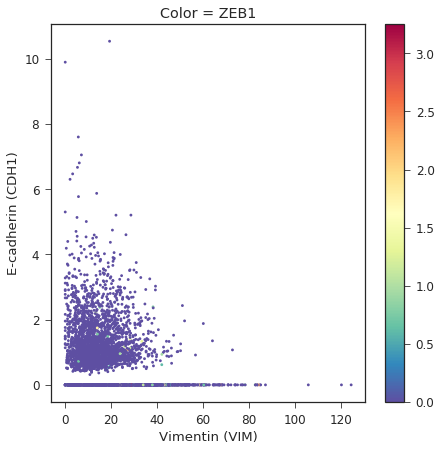

In [24]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')

#### 2D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2'], color = 'MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

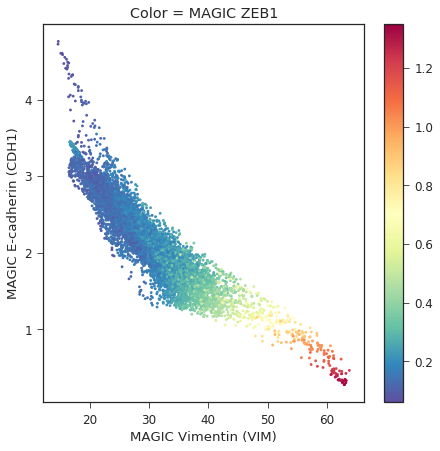

In [25]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1'], color ='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')

#### 3D scatter plot before MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

***does this look weird?**

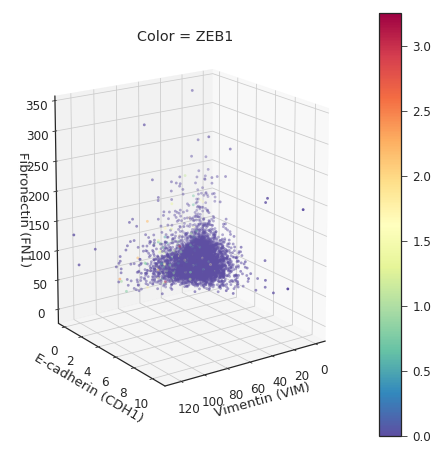

In [26]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1', 'FN1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')
ax.set_zlabel('Fibronectin (FN1)')

#### 3D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1'], color='MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')
ax.set_zlabel('MAGIC CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

(35, 150)

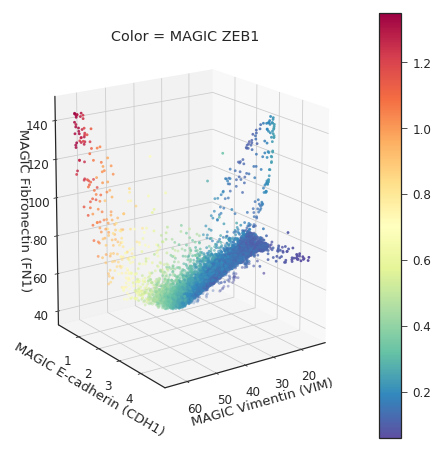

In [27]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1', 'MAGIC FN1'], color='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')
ax.set_zlabel('MAGIC Fibronectin (FN1)')
ax.set_zlim(35, 150)

<a id="magicpcaplots"></a>
### PCA scatter plots

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (before MAGIC):

### PROBLEMS:
* there's a problem with PCA scatter plot after MAGIC --> does not produce the correct results, need to look into it further
* also tSNE scatter plots don't look the exact same as MAGIC notebook's??
* didn't quite figure FigureGrid, ie how to add scatterplot info to the generated layout (can you?) --> for now, just focus on the original way to generate the figures (in magic notebook)


In [ ]:
scanalysis.plots.plot.FigureGrid(2).savefig('h')

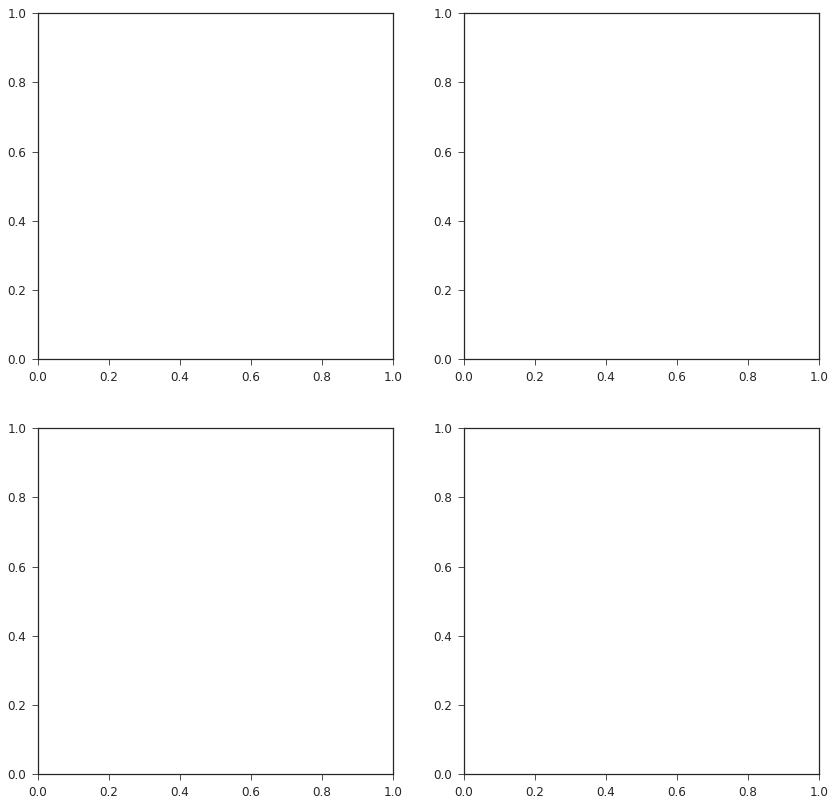

In [51]:
fig = scanalysis.plots.plot.FigureGrid(4,max_cols=2, scale=7)

In [24]:
import numpy as np

0 Axes(0.125,0.536818;0.227941x0.343182)
1 Axes(0.398529,0.536818;0.227941x0.343182)
2 Axes(0.672059,0.536818;0.227941x0.343182)
3 Axes(0.125,0.125;0.227941x0.343182)


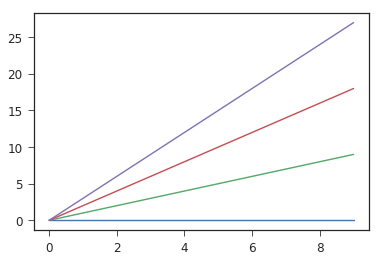

In [25]:
for i, ax in enumerate(fig):
    print(i , ax)
    plt.plot(np.arange(10) * i)

In [26]:
ax3 = fig[3]

In [33]:
fig.axes

{0: <matplotlib.axes._subplots.AxesSubplot at 0x10d3da940>,
 1: <matplotlib.axes._subplots.AxesSubplot at 0x10d510400>,
 2: <matplotlib.axes._subplots.AxesSubplot at 0x10d518cc0>,
 3: <matplotlib.axes._subplots.AxesSubplot at 0x10d2cd4a8>}

In [34]:
ax3.set_title("I'm axis 3")

In [9]:
temp.columns = ['PC1','PC2','PC3','PC4','PC5']

In [10]:
x = pd.concat([data, temp], axis=1)

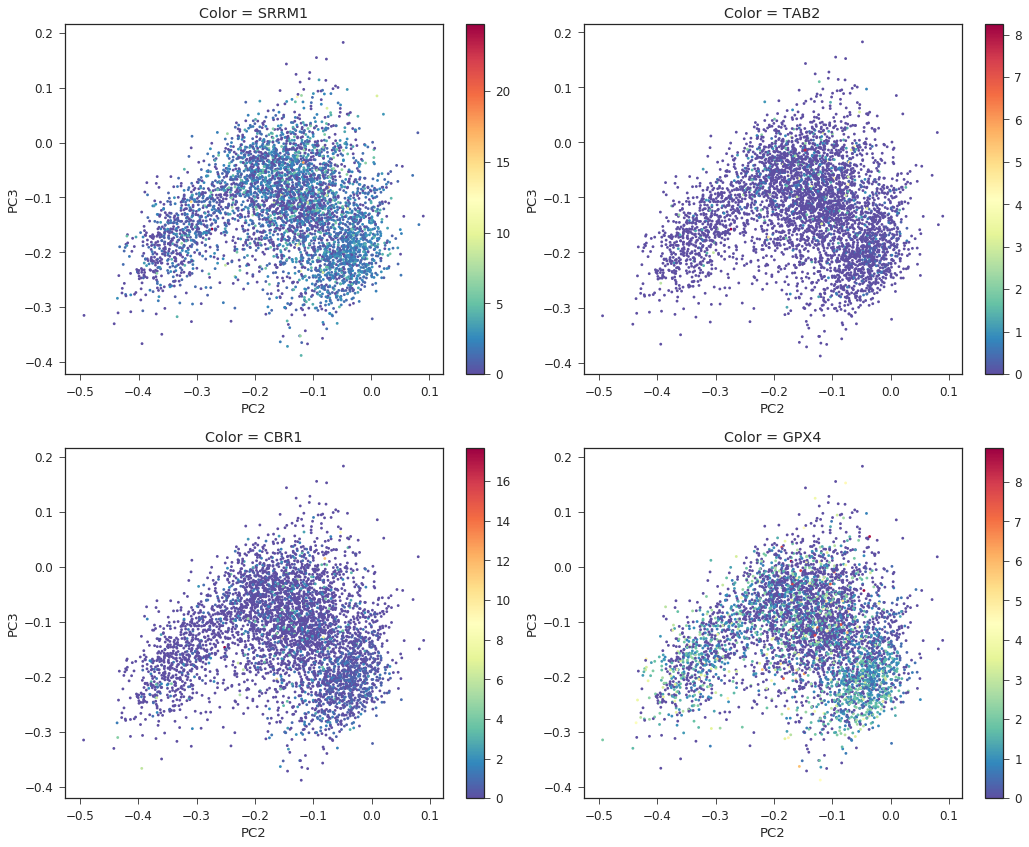

In [11]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['SRRM1', 'TAB2', 'CBR1', 'GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [21]:
pca1, pca2 = scanalysis.utils.pca.run_pca(m_data, 5)

pca1.columns = ['PC1','PC2','PC3','PC4','PC5']

x1 = pd.concat([m_data, pca1], axis=1)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


In [22]:
x1

5_8S_rRNA  A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A4GALT  \
5S_rRNA                                                                      
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
...            ...   ...       ...  ...      ...    ...        ...     ...   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       

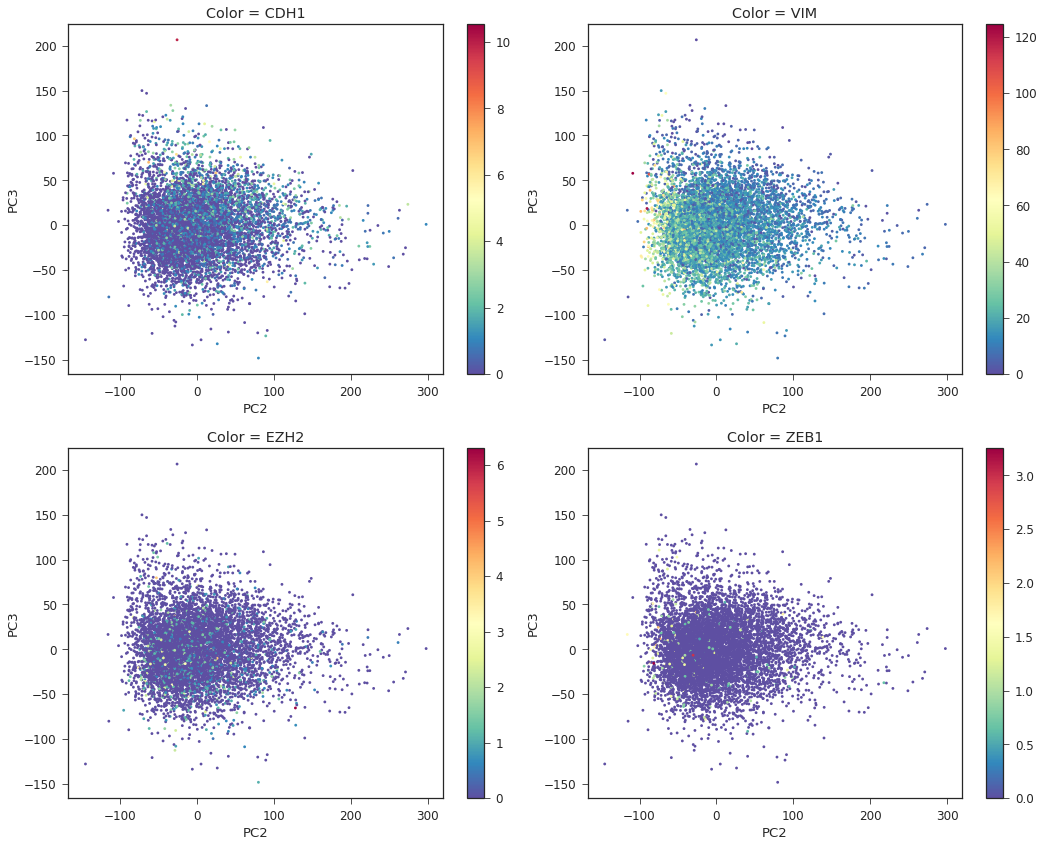

In [29]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['CDH1', 'VIM', 'EZH2', 'ZEB1']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x1, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (after MAGIC):

In [12]:
x2 = pd.concat([new_data, temp], axis=1)
x2

MAGIC SRRM1  MAGIC ZFP106  MAGIC TAB2  MAGIC TXNRD2  MAGIC GRINL1A  \
W29956     4.799335      3.512393    1.662979      0.989255       4.594722   
W30018     4.327782      3.172996    1.466589      0.810195       4.537185   
W30161     4.867862      3.677968    1.279617      1.243900       3.944221   
W30203     4.111495      2.863912    1.321292      0.818950       4.840519   
W30258     3.208078      2.187871    0.816715      0.841544       5.479361   
W30296     4.122647      3.414359    1.153301      0.786748       3.926815   
W30301     2.831760      1.893013    0.576010      0.716859       5.332766   
W30306     3.031243      2.074887    0.732690      0.763792       5.417445   
W31106     4.389177      3.984669    1.261380      0.769196       3.539324   
W31108     4.747688      4.559004    1.429199      0.861834       3.579618   
W31110     4.499369      4.064592    1.377230      0.902841       3.692192   
W31117     4.453719      3.585462    1.592731      0.863887       4.113789   
W31118     4.657782      4.264369    1.490611      0.920931       3.714212   
W31119     4.855134      3.611858    1.810589      0.869314       4.563524   
W31129     5.086360      3.827936    1.747900      1.086020       4.442907   
W31130     4.443702      3.921213    1.201526      0.726816       3.520738   
W31131     4.413208      4.050600    1.262744      0.769946       3.554117   
W31141     4.601685      3.416475    1.654028      0.830062       4.481182   
W31145     4.404780      3.898059    1.139624      0.695571       3.475521   
W31148     4.495839      4.077658    1.367478      0.840484       3.576492   
W31152     4.521613      4.024684    1.420766      0.882906       3.630511   
W31157     4.759635      3.380761    1.713600      0.990028       4.632611   
W31158     4.444752      4.103489    1.321541      0.812318       3.576006   
W31160     4.906801      4.266443    1.718327      0.914925       3.956120   
W31164     4.405475      3.994260    1.248827      0.749452       3.510163   
W31166     4.553818      3.775425    1.528261      0.833734       3.970459   
W31168     4.819307      4.324483    1.701497      0.947809       3.744341   
W31169     4.790253      4.219959    1.639397      0.942637       3.827951   
W31170     4.782913      4.580373    1.522771      0.912736       3.594542   
W31174     4.903487      3.491974    1.832144      0.975589       4.613496   
...             ...           ...         ...           ...            ...   
W75961     4.918699      3.703174    1.422597      1.283987       4.006780   
W75964     4.273236      3.381213    0.950841      0.774704       3.856723   
W75965     6.274368      3.951788    0.692988      2.591193       4.508643   
W75966     4.261860      3.112539    0.850379      0.824554       2.746566   
W75968     4.505179      3.919377    1.310364      0.870028       3.701239   
W75969     5.061911      3.871787    1.428597      1.289058       4.052895   
W75974     4.481957      3.615330    0.811418      0.720086       3.056417   
W75977     4.506165      3.686592    0.995141      0.700505       3.382301   
W75993     6.324855      3.880770    0.678601      2.772028       4.330071   
W75996     3.006787      2.024479    0.747840      0.776388       5.480062   
W76001     4.742706      3.411993    1.640907      0.991996       4.653765   
W76042     4.464572      3.682147    1.113183      0.804277       3.722120   
W76054     4.331021      3.795612    1.461152      0.924563       3.743605   
W76062     5.152447      3.878580    1.152399      1.405101       4.021089   
W76063     4.530716      3.642138    1.030641      0.736400       3.500840   
W76070     6.163314      4.255809    0.769531      2.415799       4.045731   
W76071     2.808800      1.767316    0.748569      0.754900       5.456760   
W76089     3.446633      2.430234    0.740150      0.749793       4.853889   
W76149     6.095315      3.577599    0.682323      2.710595       3.945225   
W76150     3.636710      2.619

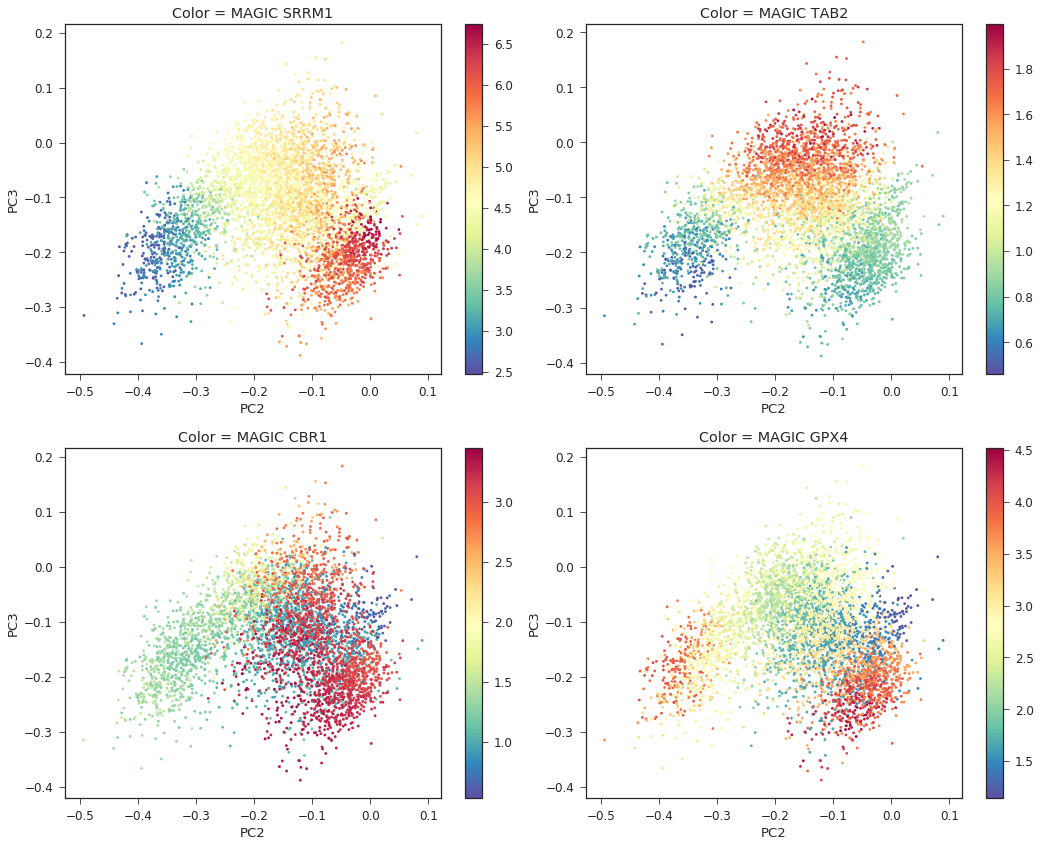

In [13]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1', 'MAGIC GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x2, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [30]:
x3 = pd.concat([new_m_data, pca1], axis=1)

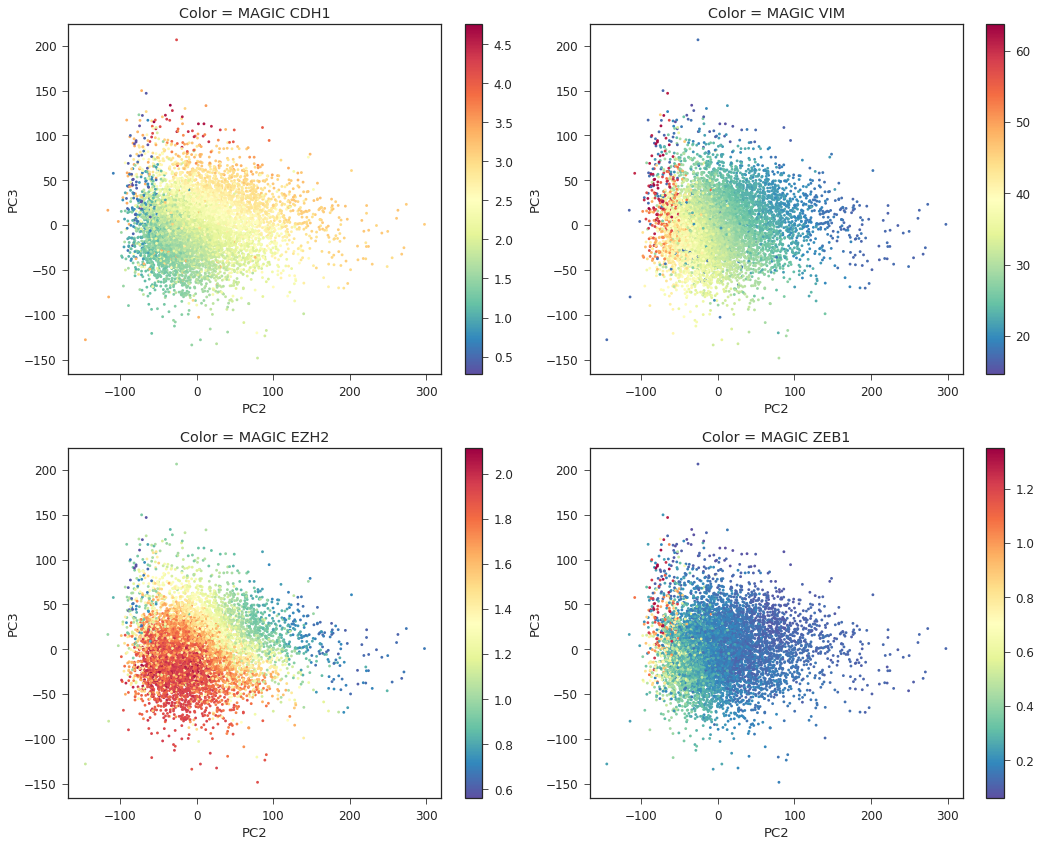

In [31]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['MAGIC CDH1', 'MAGIC VIM', 'MAGIC EZH2', 'MAGIC ZEB1']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x3, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

<a id="magictsneplots"></a>
### tSNE scatter plots

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (before MAGIC):

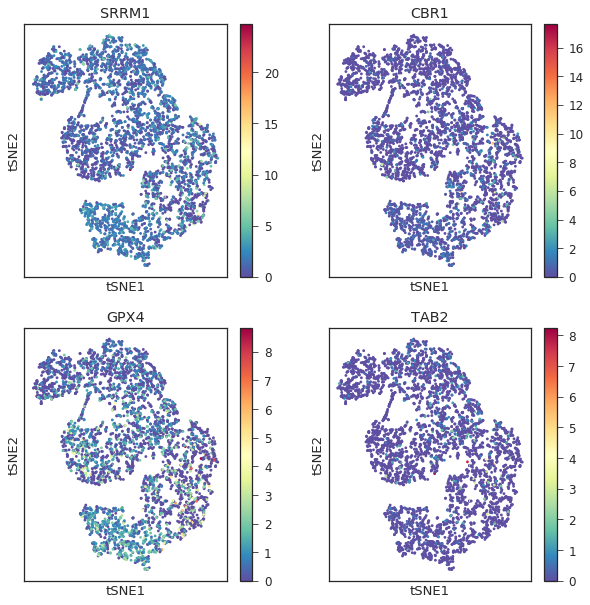

In [14]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=data, tsne=d, genes=['SRRM1', 'TAB2', 'CBR1', 'GPX4'])

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [32]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(pca1)

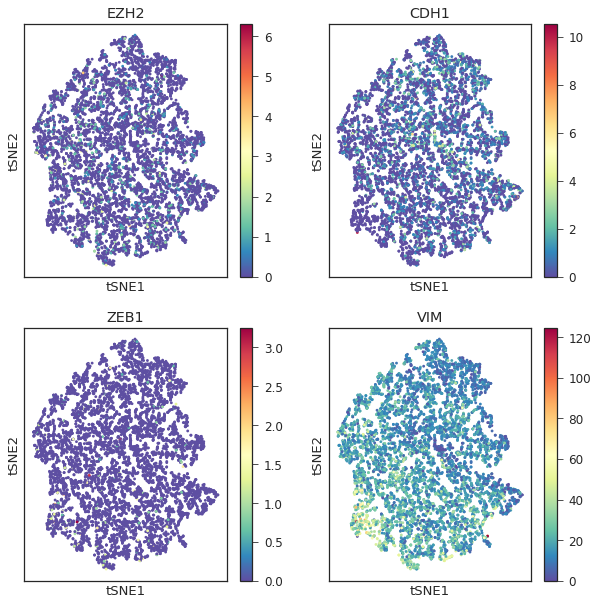

In [33]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=m_data, tsne=d1, genes=['CDH1', 'VIM', 'EZH2', 'ZEB1'])

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (after MAGIC):

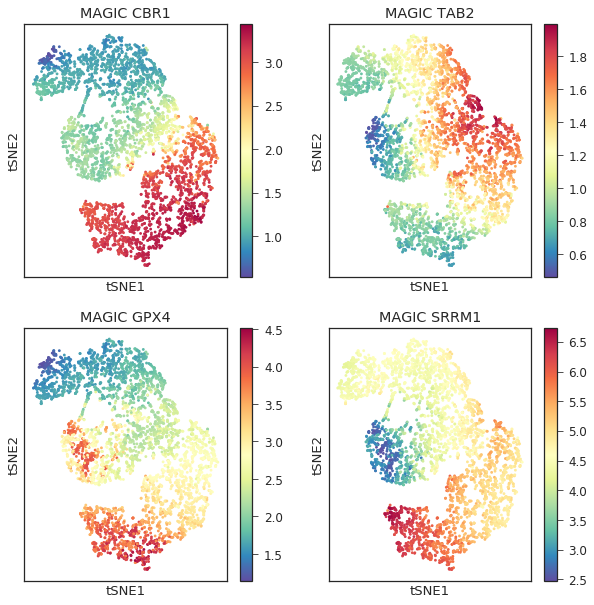

In [17]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=new_data, tsne=d, genes=['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1', 'MAGIC GPX4'])

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

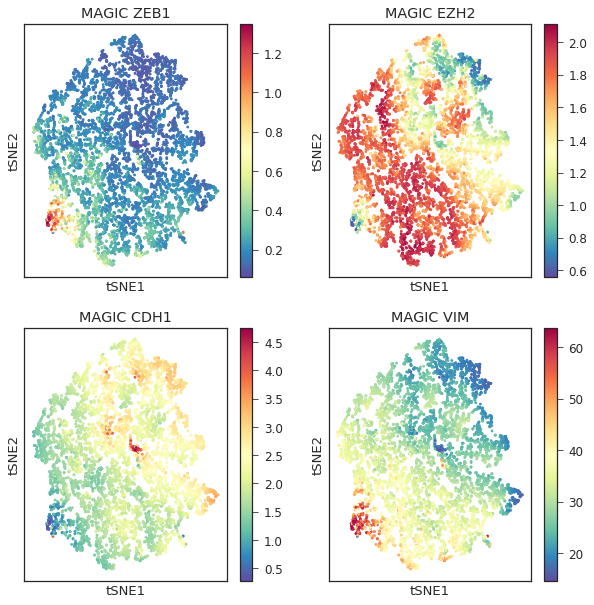

In [34]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=new_m_data, tsne=d1, genes=['MAGIC CDH1', 'MAGIC VIM', 'MAGIC EZH2', 'MAGIC ZEB1'])

<a id="savefig"></a>
## Saving figures
You can save a figure as a png file using "savefig" as shown below.

In [26]:
scanalysis.plots.plot.savefig(fig, 'h')

NameError: name 'fig' is not defined

### comparison with original MAGIC package....

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(scdata.data, ['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

In [ ]:
scdata.run_magic()

In [ ]:
scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

In [ ]:
fig, ax = scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

<a id="palantir"></a>
## Running Palantir

First, load the pickle file with the data. The data is normalized and log transformed. 

In [1]:
import scanalysis

In [2]:
mb_data = scanalysis.io.loadsave.load("~/mb_data.p")

Successfully loaded /Users/hjin/mb_data.p as a <class 'pandas.core.frame.DataFrame'> object


In [3]:
import pandas as pd
import numpy as np

We need the data to be in cells x genes format (index x columns), so in this case we will switch the rows and columns to achieve this.

In [21]:
mb_data = pd.DataFrame.transpose(mb_data)

In [22]:
mb_data

KCTD15     STT3B      NAT6      FHL2    SP140L  \
Run4_120703408880541 -3.321928 -3.321928 -3.321928  0.171306 -3.321928   
Run4_120703409056541 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703409580963 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703423990708 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703424252854 -3.321928 -0.365265 -3.321928 -3.321928 -3.321928   
Run4_120703436876077 -3.321928 -3.321928  0.363786  0.363786  0.363786   
Run4_120703455025387 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726911638237 -3.321928  0.918170 -3.321928 -3.321928 -3.321928   
Run4_120726912355038 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726924974443 -3.321928 -0.910988 -3.321928 -3.321928 -3.321928   
Run4_120726924978030 -3.321928 -0.369327 -3.321928 -3.321928 -3.321928   
Run4_120726943295348 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726943845302 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120772961130853 -3.321928 -3.321928 -3.321928  0.282395 -3.321928   
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928   
Run4_120786786086116 -3.321928  0.245224  0.245224 -3.321928  0.245224   
Run4_120786804205803 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120786804401973 -3.321928 -3.321928 -0.212571 -3.321928 -3.321928   
Run4_120797898099934 -3.321928 -0.736818 -3.321928 -3.321928 -3.321928   
Run4_120797925428019 -3.321928  0.810766 -0.109248 -3.321928 -3.321928   
Run4_120797944278244 -3.321928 -3.321928 -3.321928  0.319141 -3.321928   
Run4_120797944309486 -3.321928 -0.597133 -3.321928 -3.321928 -3.321928   
Run4_120797944462237 -3.321928  1.583616 -3.321928 -3.321928 -3.321928   
Run4_120797944538971 -3.321928 -3.321928  0.106350  1.037736 -3.321928   
Run4_120797945084765 -3.321928  1.128506 -3.321928 -3.321928 -3.321928   
Run4_120864497952619 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_121202296155437 -0.803194 -0.803194 -0.803194  0.065101 -0.803194   
Run4_121202296712412 -3.321928  0.731223 -3.321928 -3.321928 -3.321928   
Run4_121202296875939 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_121202311609131 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
...                        ...       ...       ...       ...       ...   
Run5_240634599983342 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_240634599986987  0.702973  0.702973 -3.321928 -3.321928 -3.321928   
Run5_240634613909861 -3.321928  0.388657 -3.321928 -0.505150 -3.321928   
Run5_240634614373595 -3.321928 -0.022172 -0.022172 -3.321928 -3.321928   
Run5_240634614729955 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_240634626784550 -3.321928 -3.321928 -3.321928  1.289575 -3.321928   
Run5_240634645855022 -3.321928 -0.151090 -3.321928 -3.321928 -0.151090   
Run5_240634646116662 -3.321928 -3.321928 -3.321928  0.543496 -3.321928   
Run5_241057653508843 -3.321928 -3.321928  0.102278 -3.321928 -3.321928   
Run5_241057653738918 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057654294885 -3.321928  0.719076  0.719076 -3.321928 -3.321928   
Run5_241057668712349 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057680972510 -3.321928 -3.321928  0.131881 -3.321928 -3.321928   
Run5_241057681259245 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057700113179 -3.321928  0.200470 -3.321928 -3.321928  0.200470   
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241098858810213 -3.321928  0.910984 -0.014261 -3.321928 -3.321928   
Run5_241098873552118 -3.321928  0.099779 -3.321928 -3.321928 -3.321928   
Run5_241098885647774 -3.321928 -3.321928 -3.321928  1.098178 -3.321928   
Run5_241098904976174 -0.080268 -0.080268 -3.321928 -3.321928 -3.321928   
Run5_241098905205038 -3.321928 -3.321928 -3.321928  0.590031 -3.321928   
Run5_241106375007076 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241106389756316 -3.3219

In [6]:
DMEigVals = scanalysis.io.loadsave.load("~/palantir/dm_eig_vals.csv")

Successfully loaded /Users/hjin/palantir/dm_eig_vals.csv as a pd.DataFrame object


In [7]:
DMEigs = scanalysis.io.loadsave.load("~/palantir/dm_eigs.csv")

Successfully loaded /Users/hjin/palantir/dm_eigs.csv as a pd.DataFrame object


Note: the run_multibranch function takes ~10 minutes.

In [8]:
atrajectory = scanalysis.io.loadsave.load("~/palantir/trajectory.csv")

Successfully loaded /Users/hjin/palantir/trajectory.csv as a pd.DataFrame object


Use the following parameters when running run_multibranch for this particular data set:
* start_cell: Run5_126835192163230
* num_waypoints: 300
* flock = 0

In [51]:
res = scanalysis.tools.pr.palantir.run_multibranch(data_ = mb_data, DMEigs = DMEigs, DMEigVals = DMEigVals, dm_eigs = [1,2,3], start_cell="Run5_126835192163230", num_waypoints = 300, flock = 0)


Sampling and flocking waypoints...
Time for determining waypoints: 0.0020545363426208497 minutes
Shortest path distances...
Time for shortest paths: 6.511597116788228 minutes
Determining perspectives, trajectory...
Correlation at iteration 1: 1.0000
Determining terminal states...
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/usr/local/lib/python3.6/site-packages/scanalysis/tools/pr/palantir.py:162: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(pairwise_distances(data.loc[cells,:]))
/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Compare trajectory results with the trajectory.csv file using a scatter plot, shown below.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(res['trajectory'], atrajectory)

<a id="prplot"></a>
## Plotting Palantir Results

In [27]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

First, create an instance of the DiffEntrResults class.

In [52]:
der = scanalysis.plots.pr_plot.DiffEntrResults(trajectory = res['trajectory'], branches = None, branch_prob=res['branch_probs'], no_bins=500)

Here, we will try the first five genes in the data matrix. You shouldn't plot all the markers because that will kill your computer.  

In [24]:
mb_data_f5 = mb_data.iloc[:,0:5]

In [25]:
mb_data_f5

KCTD15     STT3B      NAT6      FHL2    SP140L
Run4_120703408880541 -3.321928 -3.321928 -3.321928  0.171306 -3.321928
Run4_120703409056541 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703409580963 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703423990708 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703424252854 -3.321928 -0.365265 -3.321928 -3.321928 -3.321928
Run4_120703436876077 -3.321928 -3.321928  0.363786  0.363786  0.363786
Run4_120703455025387 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726911638237 -3.321928  0.918170 -3.321928 -3.321928 -3.321928
Run4_120726912355038 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726924974443 -3.321928 -0.910988 -3.321928 -3.321928 -3.321928
Run4_120726924978030 -3.321928 -0.369327 -3.321928 -3.321928 -3.321928
Run4_120726943295348 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726943845302 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120772961130853 -3.321928 -3.321928 -3.321928  0.282395 -3.321928
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928
Run4_120786786086116 -3.321928  0.245224  0.245224 -3.321928  0.245224
Run4_120786804205803 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120786804401973 -3.321928 -3.321928 -0.212571 -3.321928 -3.321928
Run4_120797898099934 -3.321928 -0.736818 -3.321928 -3.321928 -3.321928
Run4_120797925428019 -3.321928  0.810766 -0.109248 -3.321928 -3.321928
Run4_120797944278244 -3.321928 -3.321928 -3.321928  0.319141 -3.321928
Run4_120797944309486 -3.321928 -0.597133 -3.321928 -3.321928 -3.321928
Run4_120797944462237 -3.321928  1.583616 -3.321928 -3.321928 -3.321928
Run4_120797944538971 -3.321928 -3.321928  0.106350  1.037736 -3.321928
Run4_120797945084765 -3.321928  1.128506 -3.321928 -3.321928 -3.321928
Run4_120864497952619 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_121202296155437 -0.803194 -0.803194 -0.803194  0.065101 -0.803194
Run4_121202296712412 -3.321928  0.731223 -3.321928 -3.321928 -3.321928
Run4_121202296875939 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_121202311609131 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
...                        ...       ...       ...       ...       ...
Run5_240634599983342 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634599986987  0.702973  0.702973 -3.321928 -3.321928 -3.321928
Run5_240634613909861 -3.321928  0.388657 -3.321928 -0.505150 -3.321928
Run5_240634614373595 -3.321928 -0.022172 -0.022172 -3.321928 -3.321928
Run5_240634614729955 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634626784550 -3.321928 -3.321928 -3.321928  1.289575 -3.321928
Run5_240634645855022 -3.321928 -0.151090 -3.321928 -3.321928 -0.151090
Run5_240634646116662 -3.321928 -3.321928 -3.321928  0.543496 -3.321928
Run5_241057653508843 -3.321928 -3.321928  0.102278 -3.321928 -3.321928
Run5_241057653738918 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057654294885 -3.321928  0.719076  0.719076 -3.321928 -3.321928
Run5_241057668712349 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057680972510 -3.321928 -3.321928  0.131881 -3.321928 -3.321928
Run5_241057681259245 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057700113179 -3.321928  0.200470 -3.321928 -3.321928  0.200470
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241098858810213 -3.321928  0.910984 -0.014261 -3.321928 -3.321928
Run5_241098873552118 -3.321928  0.099779 -3.321928 -3.321928 -3.321928
Run5_241098885647774 -3.321928 -3.321928 -3.321928  1.098178 -3.321928
Run5_241098904976174 -0.080268 -0.080268 -3.321928 -3.321928 -3.321928
Run5_241098905205038 -3.321928 -3.321928 -3.321928  0.590031 -3.321928
Run5_241106375007076 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241106389756316 -3.321928  1.671793 -3.321928 -3.321928 -3.321928
Run5_241106389784372 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241106401770805 -3.321928  1.560339 -3.3219

Run the plot_markers function to visualize results.

### PROBLEM: 
when compute_std parameter is set to True, results in ValueError, what seems to be happening is that the the program is trying to reshape the original array of 5 (which holds the trends) into array of dimensions 5x500, but it can't because there are only 5 elements in the original array. 500 is derived from the traj_bins instance variable, which was initialized according to the no_bins parameter. In reality, the trends array can only be reshaped into an array of 5x1 dimensions... so I was wondering, is the length of trends correct?

In [39]:
der.compute_marker_trends(mb_data_f5, der.branch_prob.columns, True, n_jobs=1)

Run4_235626713532342


ValueError: cannot reshape array of size 5 into shape (5,500)

It works when compute_std parameter is set to False, shown below:

In [70]:
der.compute_marker_trends(mb_data_f5, der.branch_prob.columns, False, n_jobs=1)

Run4_235626713532342
Time for processing Run4_235626713532342: 0.0054917494455973305 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.006096184253692627 minutes


OrderedDict([('Run4_235626713532342',
                      0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              KCTD15 -3.223099 -3.223028 -3.222957 -3.222886 -3.222815 -3.222744 -3.222674   
              STT3B  -1.899472 -1.895464 -1.891456 -1.887448 -1.883441 -1.879435 -1.875431   
              NAT6   -3.053313 -3.047765 -3.042217 -3.036669 -3.031121 -3.025572 -3.020022   
              FHL2   -3.104127 -3.095858 -3.087588 -3.079319 -3.071050 -3.062780 -3.054511   
              SP140L -2.969632 -2.969176 -2.968720 -2.968264 -2.967809 -2.967353 -2.966897   
              
                      0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              KCTD15 -3.222604 -3.222536 -3.222468    ...    -2.730947 -2.723237 -2.715514   
              STT3B  -1.871431 -1.867434 -1.863443    ...    -1.739299 -1.741062 -1.742821   
              NAT6   -3.014470 -3.008916 -3.003359    ...    -2.888668 -2.894655 -2.900639   
       

In [73]:
der.branch_prob

Run4_235626713532342  Run5_239477254471070
Run4_120703408880541              0.999798              0.000000
Run4_120703409056541              0.110741              0.889259
Run4_120703409580963              0.000000              0.997921
Run4_120703423990708              0.000000              0.997921
Run4_120703424252854              0.000000              0.999894
Run4_120703436876077              0.085335              0.914665
Run4_120703455025387              0.000000              0.998921
Run4_120726911638237              0.000000              0.999310
Run4_120726912355038              0.000000              0.993738
Run4_120726924974443              0.000000              0.997403
Run4_120726924978030              0.000000              0.990156
Run4_120726943295348              0.000000              0.997921
Run4_120726943845302              0.000000              0.997923
Run4_120772961130853              0.069634              0.930366
Run4_120786758780660              0.078360              0.921640
Run4_120786786086116              0.107859              0.892141
Run4_120786804205803              0.000000              0.999359
Run4_120786804401973              0.000000              0.994719
Run4_120797898099934              0.000000              0.999134
Run4_120797925428019              0.000000              0.990109
Run4_120797944278244              0.999937              0.000000
Run4_120797944309486              0.999670              0.000000
Run4_120797944462237              0.015449              0.984551
Run4_120797944538971              0.990191              0.000000
Run4_120797945084765              0.081308              0.918692
Run4_120864497952619              0.000000              0.999971
Run4_121202296155437              0.999964              0.000000
Run4_121202296712412              0.000000              0.999903
Run4_121202296875939              0.110758              0.889242
Run4_121202311609131              0.000000              0.997920
...                                    ...                   ...
Run5_240634599983342              0.000000              0.997603
Run5_240634599986987              0.110741              0.889259
Run5_240634613909861              0.999998              0.000000
Run5_240634614373595              0.000000              0.997413
Run5_240634614729955              0.000000              0.997921
Run5_240634626784550              0.999952              0.000000
Run5_240634645855022              0.999941              0.000000
Run5_240634646116662              0.110441              0.889559
Run5_241057653508843              0.010486              0.989514
Run5_241057653738918              0.000000              0.997918
Run5_241057654294885              0.110743              0.889257
Run5_241057668712349              0.110758              0.889242
Run5_241057680972510              0.000000              0.995669
Run5_241057681259245              0.031445              0.968555
Run5_241057700113179              0.012885              0.987115
Run5_241098858613659              0.110460              0.889540
Run5_241098858810213              0.101612              0.898388
Run5_241098873552118              0.000000              0.992893
Run5_241098885647774              0.999969              0.000000
Run5_241098904976174              0.013091              0.986909
Run5_241098905205038              0.000000              0.998724
Run5_241106375007076              0.999990              0.000000
Run5_241106389756316              0.000000              0.999840
Run5_241106389784372              0.000000              0.999028
Run5_241106401770805              0.000000              0.999763
Run5_241114577000174              0.011438              0.988562
Run5_241114577004764              0.000000              0.999087
Run5_241114589051630              0.999998              0.000000
Run5_241114589051819              0.000000              0.998088
Run5_241114589128940              0.443230              0

Run4_235626713532342
Time for processing Run4_235626713532342: 0.010077027479807536 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.008325831095377604 minutes


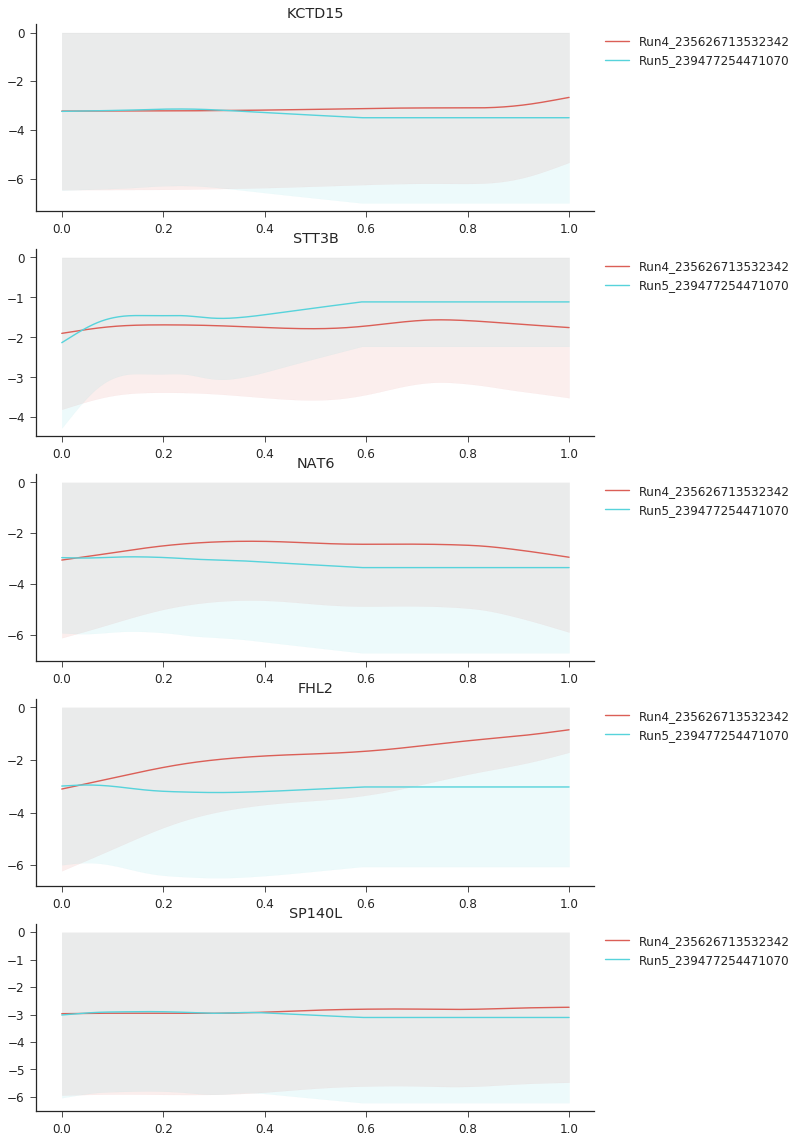

In [71]:
der.plot_markers(mb_data_f5, branches = der.branch_prob.columns)

Let's see the tSNE maps of this particular dataset.

In [5]:
m, n = scanalysis.utils.pca.run_pca(mb)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


In [7]:
t2 = scanalysis.utils.tsne.TSNE()
d2 = t2.fit_transform(m)

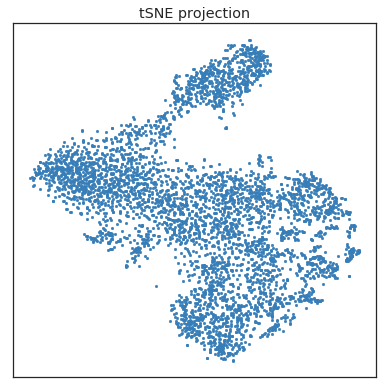

In [11]:
fig, ax = scanalysis.plots.plot.plot_tsne(d2)

(<matplotlib.figure.Figure at 0x11aceceb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11aabcb00>)

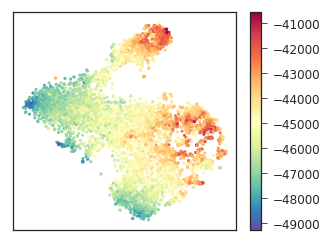

In [28]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(mb, d2, fig = fig)

Please make sure that the tSNE data entered corresponds to the Wishbone object you've entered.
    If yes, press enter to continue.
    If not, Ctrl-C to exit and retry with correct parameters.


AttributeError: 'DiffEntrResults' object has no attribute 'branch'

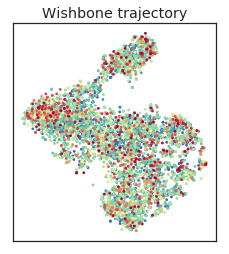

In [43]:
fig, ax = scanalysis.plots.wb_plot.plot_wishbone_on_tsne(der, d2)

Use the tSNE data provided by Manu.

In [45]:
tsne = scanalysis.io.loadsave.load('~/tsne.csv')

Successfully loaded /Users/hjin/tsne.csv as a pd.DataFrame object


Filter out and only include the tSNE data that corresponds to the original mb_data dataset. In other words, filter out to take only the cell names in the index of mb_data from tSNE data.

In [47]:
tsne1 = tsne.loc[mb_data.index]

### PROBLEM:
currently, there is a problem because the plot_palantir_on_tsne function is not used to taking multiple columns of the DiffEntrResults.branch_prob matrix... it can only accept one column at a time so this was "solved" by only plotting one column at a time as shown by the three graphs below

In [43]:
scanalysis.plots.pr_plot.plot_palantir_on_tsne(der, tsne1)

NameError: name 'tsne1' is not defined

alternatively, we will plot the tsne map colored by the different branch probabilities

ie. similar to the trajectory, make a tsne map each for each column of the branch probability matrix.

In [1]:
# column 0, Run4_235626713532342

fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,0])

NameError: name 'plt' is not defined

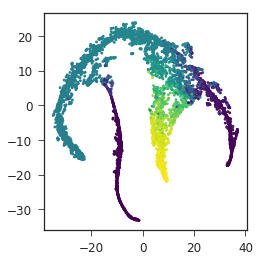

In [107]:
# column 1, Run5_161340154039083
fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,1])

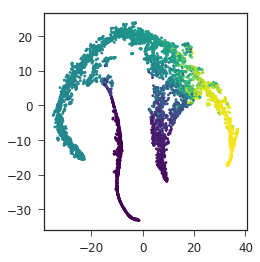

In [108]:
# column 2, Run5_239477254471070
fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,2])

In [39]:
data_part = mb_data.loc[:,['HBB', 'CD34', 'MPO', 'LYZ', 'CST3']]

In [40]:
data_part

HBB      CD34       MPO       LYZ      CST3
Run4_120703408880541 -3.321928  0.171306 -3.321928  0.171306  2.645347
Run4_120703409056541 -3.321928  0.837003  0.837003 -3.321928 -3.321928
Run4_120703409580963 -3.321928 -3.321928  4.974236  6.386403  0.880299
Run4_120703423990708 -3.321928 -3.321928  5.063559  3.296390 -3.321928
Run4_120703424252854 -3.321928  0.538690 -3.321928 -0.365265 -3.321928
Run4_120703436876077 -3.321928 -3.321928  0.363786 -3.321928  0.363786
Run4_120703455025387 -3.321928 -0.270688 -0.270688 -3.321928 -3.321928
Run4_120726911638237 -3.321928  0.370883 -3.321928 -3.321928 -0.521655
Run4_120726912355038 -0.098613  0.822005  4.912722 -3.321928 -0.098613
Run4_120726924974443 -3.321928 -3.321928  4.006959 -0.910988 -0.053432
Run4_120726924978030 -3.321928  1.795234 -3.321928 -0.369327  0.534347
Run4_120726943295348 -3.321928 -3.321928  4.910699  6.399458  0.980907
Run4_120726943845302 -3.321928 -3.321928  5.758552  5.531596 -3.321928
Run4_120772961130853 -3.321928  1.221830 -3.321928 -3.321928  0.282395
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928
Run4_120786786086116 -3.321928 -3.321928  0.245224 -3.321928 -3.321928
Run4_120786804205803 -3.321928 -0.443817 -3.321928 -3.321928  0.454569
Run4_120786804401973 -3.321928  1.256403 -3.321928 -3.321928 -3.321928
Run4_120797898099934 -3.321928 -0.736818  5.070566  2.608983  0.678238
Run4_120797925428019 -3.321928  0.810766 -3.321928 -3.321928  0.810766
Run4_120797944278244 -0.569621  0.319141 -3.321928 -3.321928  2.041438
Run4_120797944309486 -3.321928 -3.321928 -3.321928 -0.597133  0.289401
Run4_120797944462237 -3.321928  1.986570 -3.321928 -3.321928 -3.321928
Run4_120797944538971 -3.321928  1.037736 -3.321928 -3.321928 -3.321928
Run4_120797945084765  1.128506 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120864497952619 -3.321928 -3.321928  3.539276  5.588708  2.836658
Run4_121202296155437 -3.321928  0.065101 -0.803194 -0.803194  1.770428
Run4_121202296712412  0.731223 -3.321928  0.731223 -3.321928  1.687102
Run4_121202296875939 -3.321928  1.577101 -3.321928  0.624661 -3.321928
Run4_121202311609131  0.335232 -3.321928  4.975569  5.742348  2.246810
...                        ...       ...       ...       ...       ...
Run5_240634599983342 -3.321928 -3.321928  4.334501  3.686505  2.478976
Run5_240634599986987 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634613909861  4.089875 -3.321928 -3.321928 -0.505150  1.332478
Run5_240634614373595 -3.321928  1.461658  0.902651 -3.321928 -3.321928
Run5_240634614729955 -3.321928 -3.321928  5.754522  6.201268 -3.321928
Run5_240634626784550 -0.181935 -3.321928 -3.321928 -3.321928  2.002738
Run5_240634645855022 -3.321928 -3.321928 -3.321928 -3.321928  0.766502
Run5_240634646116662 -3.321928  2.060912 -3.321928 -3.321928 -3.321928
Run5_241057653508843 -3.321928 -3.321928 -3.321928 -3.321928  0.102278
Run5_241057653738918 -3.321928 -3.321928  5.097710  2.069387 -3.321928
Run5_241057654294885 -3.321928  2.651800 -3.321928 -3.321928 -3.321928
Run5_241057668712349 -3.321928  1.687102 -3.321928 -3.321928 -3.321928
Run5_241057680972510 -3.321928  0.131881  0.131881 -3.321928  0.131881
Run5_241057681259245 -3.321928 -3.321928  0.644397 -3.321928  2.166477
Run5_241057700113179 -3.321928  1.136287  0.200470 -3.321928  1.136287
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928  0.729147
Run5_241098858810213 -3.321928 -3.321928  4.011044 -3.321928 -0.014261
Run5_241098873552118 -3.321928  1.030843 -3.321928 -3.321928 -3.321928
Run5_241098885647774 -3.321928 -0.357935 -3.321928 -3.321928  1.496269
Run5_241098904976174  0.841381 -0.080268 -3.321928 -3.321928 -3.321928
Run5_241098905205038 -3.321928  0.590031  0.590031 -3.321928  0.590031
Run5_241106375007076 -3.321928 -0.487455 -3.321928 -3.321928  1.662848
Run5_241106389756316 -3.321928  1.271771 -0.198384 -3.321928  1.984637
Run5_241106389784372 -0.212452 -0.212452 -3.321928 -0.212452 -0.212452
Run5_241106401770805 -3.321928  1.560339  0.070037 

In [65]:
der.compute_marker_trends(data_part, None, False, n_jobs=1)

Run4_235626713532342
Time for processing Run4_235626713532342: 0.007353278001149496 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.0060695171356201175 minutes


OrderedDict([('Run4_235626713532342',
                    0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              HBB  -2.882329 -2.880283 -2.878237 -2.876191 -2.874144 -2.872097 -2.870049   
              CD34 -1.162154 -1.155668 -1.149184 -1.142700 -1.136218 -1.129739 -1.123264   
              MPO  -2.476619 -2.470871 -2.465124 -2.459376 -2.453628 -2.447879 -2.442128   
              LYZ  -2.693912 -2.692962 -2.692013 -2.691064 -2.690115 -2.689166 -2.688216   
              CST3 -1.026968 -1.028262 -1.029555 -1.030847 -1.032137 -1.033422 -1.034702   
              
                    0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              HBB  -2.867999 -2.865947 -2.863891    ...     2.635462  2.719464  2.803568   
              CD34 -1.116793 -1.110330 -1.103874    ...    -2.557039 -2.577816 -2.598607   
              MPO  -2.436377 -2.430625 -2.424873    ...    -1.747190 -1.741115 -1.735039   
              LYZ  -2.68726

Run4_235626713532342
Time for processing Run4_235626713532342: 0.010553383827209472 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.0065901875495910645 minutes


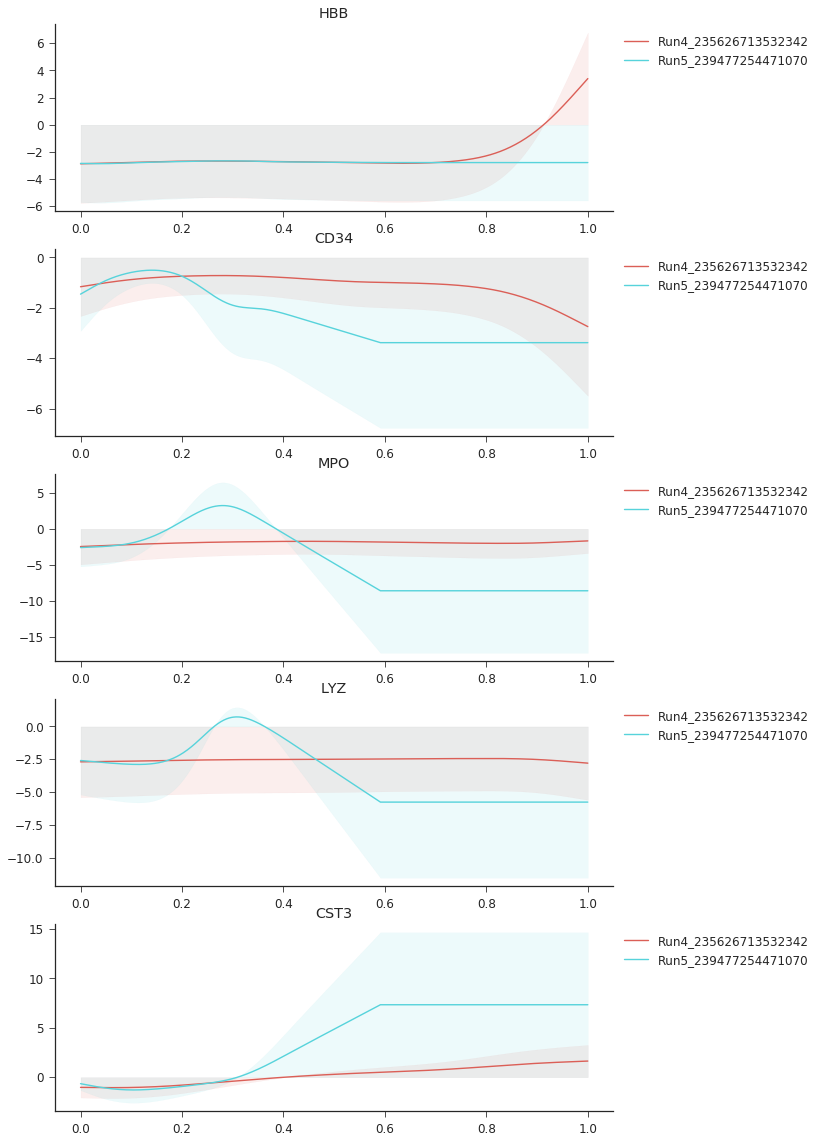

In [66]:
der.plot_markers(data_part)

In [67]:
trends = scanalysis.io.loadsave.load("~/trends.p")

Successfully loaded /Users/hjin/trends.p as a <class 'collections.OrderedDict'> object


In [68]:
trends

OrderedDict([('Run4_235626713532342',
                      0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              KCTD15 -3.232311 -3.232019 -3.231727 -3.231436 -3.231144 -3.230853 -3.230562   
              STT3B  -2.121511 -2.114979 -2.108448 -2.101917 -2.095387 -2.088857 -2.082327   
              NAT6   -3.008021 -3.007220 -3.006418 -3.005616 -3.004814 -3.004011 -3.003208   
              FHL2   -3.080830 -3.077146 -3.073462 -3.069778 -3.066094 -3.062410 -3.058725   
              SP140L -3.010032 -3.008821 -3.007610 -3.006399 -3.005188 -3.003978 -3.002768   
              
                      0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              KCTD15 -3.230271 -3.229980 -3.229691    ...    -2.702542 -2.702542 -2.702542   
              STT3B  -2.075798 -2.069270 -2.062743    ...    -1.747917 -1.747917 -1.747917   
              NAT6   -3.002405 -3.001601 -3.000795    ...    -2.920024 -2.920024 -2.920024   
       

<a id="ref"></a>
## References

Setty M, Tadmor MD, Reich-Zeliger S, Angel O, Salame TM, Kathail P, Choi K, Bendall S, Friedman N, Pe’er D. "Wishbone identifies bifurcating developmental trajectories from single-cell data." Nat. Biotech. 2016 April 12. <http://dx.doi.org/10.1038/nbt.3569>

van Dijk, David, et al. "MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data." BioRxiv (2017): 111591. <http://www.biorxiv.org/content/early/2017/02/25/111591>